# present utils.py file in same directory

In [ ]:
# utils.py
import pandas as pd
import numpy as np

import random

import category_encoders as ce
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
import bisect

from sklearn.preprocessing import OneHotEncoder

import shap

from hyperopt import fmin, tpe, hp, anneal, Trials

import os
import gc

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

def process_data(path, drop_columns):
    """Read data, drop columns and do processing
    Parameters
    ----------
    path : String
    drop_columns : List

    Returns
    -------
    df :  DataFrame
    """
    df = pd.read_csv(path).drop(columns = drop_columns)
    return df

def understand_data(df, id_cols):
    """Print Numeric & Categorical columns separately,
    Print columnwise null counts,
    Print Columns with 0 Variance
    Parameters
    ----------
    df : DataFrame
    id_cols : List

    Returns
    -------
    """
    print(f"Numeric Columns : {list(df.drop(columns = id_cols)._get_numeric_data().columns)}")
    print("")
    print(f"Categorical Columns : {list(df.drop(columns = id_cols).select_dtypes(include=['category', 'object']))}")
    print("")
    print(f"Null Counts")
    print(df.drop(columns = id_cols).isna().sum())
    print("")
    print(f"Zero Variance Columns: {df.drop(columns = id_cols)._get_numeric_data().loc[:, df.drop(columns = id_cols)._get_numeric_data().std() == 0].columns}")

def data_split(df):
    """Split data in train, val, hold_out
    Parameters
    ----------
    df : DataFrame

    Returns
    -------
    train :  DataFrame,
    val :  DataFrame,
    hold_out :  DataFrame
    """
    train = df[df.yearmo<=202203]
    val = df[df.yearmo==202204]
    hold_out = df[df.yearmo==202205]

    return train.reset_index(drop = True), val.reset_index(drop = True), hold_out.reset_index(drop = True)

def univariate_stats(df, id_cols):
    """Returns Univatiate stats for numeric and categorical variables
    Parameters
    ----------
    df : DataFrame
    id_cols : List

    Returns
    -------
    df._get_numeric_data().describe() :  DataFrame
    df.select_dtypes(include=['category', 'object']).describe() :  DataFrame
    """
    return df.drop(columns = id_cols)._get_numeric_data().describe(), df.drop(columns = id_cols).select_dtypes(include=['category', 'object']).describe()


def dpd_roll_rate(df):
    """DPD Roll Rate Analysis,
    number and % of customer passed the particular dpd
    Parameters
    ----------
    df : DataFrame

    Returns
    -------
    dpd_flow : DataFrame
    """

    dpd_flow = pd.DataFrame(columns = ["dpd","user_count"])
    for dpd in [0,30,60,90]:
        user_count = len(df[df.max_dpd>=dpd])
        dpd_flow.loc[len(dpd_flow.index)] = [dpd, user_count]
    dpd_flow['user_count']  = dpd_flow['user_count'].astype(int)
    dpd_flow['user_percent'] = (dpd_flow['user_count']*100/max(dpd_flow['user_count'])).round(2).astype(str)+' %'
    return dpd_flow


def window_roll_rate(df, dpd):
    """Window Roll Rate Analysis,
    First EMI of reaching dpd >= X, count and % by First EMI
    Parameters
    ----------
    df : DataFrame
    dpd : Int (30, 60, 90)

    Returns
    -------
    window_roll : DataFrame
    """
    df2 = df[df.max_dpd>=dpd]
    df2['first_deafult'] = np.where(df2.emi_1_dpd>=dpd, 1,
                                   np.where(df2.emi_2_dpd>=dpd, 2,
                                           np.where(df2.emi_3_dpd>=dpd, 3,
                                                   np.where(df2.emi_4_dpd>=dpd, 4,
                                                           np.where(df2.emi_5_dpd>=dpd, 5,
                                                                   np.where(df2.emi_6_dpd>=dpd, 6, 0))))))

    window_roll = df2.groupby('first_deafult')['User_id'].count().reset_index()
    window_roll['user_percent'] = (window_roll['User_id']*100/sum(window_roll['User_id'])).round(2).astype(str)+' %'
    window_roll.columns = ['first_default_emi','users_count', '% of Users']
    return window_roll

def create_label(df, dpd, months):
    """Genrate label according to dpd in months,
    returns dataframe with label columns
    Parameters
    ----------
    df : DataFrame
    dpd : Int (30, 60, 90)
    months : Int (1,2,3,4,5,6)

    Returns
    -------
    df : DataFrame
    """
    months = ["emi_"+str(x)+"_dpd" for x in range(1, months+1)]
    df['label'] = np.where(df[months].max(axis = 1)>=dpd, 1, 0)
    print("label columns added to dataframe")
    return df

def label_distribution(data_list, data_list_name, label_name):
    """Print label distribution of list of dataframes
    ----------
    data_list : List of DataFrames
    data_list_name : List of Data Type (like Training, Validation)
    label_name : String (Column Name of Label)

    Returns
    -------
    """
    i = 0
    for d in data_list:
        label_distribution = pd.DataFrame(d[label_name].value_counts()).reset_index()
        label_distribution.columns = [label_name, 'user_count']
        label_distribution['% users'] = label_distribution['user_count']*100/sum(label_distribution['user_count'])
        print("")
        print(f"label distribution of {data_list_name[i]}")
        print(label_distribution)
        i = i+1

def derived_features(df):
    """Create Some Features
    ----------
    df : DataFrame

    Returns
    -------
    df : DataFrame
    """
    df['interest_received_ratio'] = (df['interest_received']/df['total_payement']).replace([np.inf, -np.inf], 0).fillna(0)
    df['total_payement_per_loan'] = (df['total_payement']/df['number_of_loans']).replace([np.inf, -np.inf], 0).fillna(0)
    df['delinq_2yrs_ratio'] = (df['delinq_2yrs']/df['number_of_loans']).replace([np.inf, -np.inf], 0).fillna(0)
    return df

class eda:
    """EDA Class
    - Univarite EDA
      - Numeric Features Summary
      - Categorical Features Summary
    - Bivariate EDA
      - Correlation Plot
      - Box Plot"""
    def __init__(self, df, id_cols):
        """Initialize Class
        Parameters
        ----------
        df : DataFrame
        id_cols : List
        """
        self.df = df
        self.id_cols = id_cols
        self.num_cols = df.drop(columns = id_cols)._get_numeric_data().columns
        self.cat_cols = df.drop(columns = id_cols).select_dtypes(include=['category', 'object']).columns

    def numeric_summary(self):
        """Summary of Numeric Features"""
        return self.df[self.num_cols].describe()

    def categorical_summary(self):
        """Summary of Categorical Features"""
        return self.df[self.cat_cols].describe()

    def correlation_plot(self):
        """Correlation Plot of Numerical Features"""
        corr = self.df[self.num_cols].corr()

        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True

        plt.figure(figsize=(len(corr.columns)+5, len(corr.columns)+5))
        with sns.axes_style("white"):
            ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(30, 220, n=200),
                             square=True, annot=True)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_autoscalex_on(True)
        ax.set_autoscaley_on(True)
        ax.set_title("Correlation Plot of Numerical Features")

        plt.show()

    def box_plot(self, group):
        """Box Plot of Numerical Features vs Group Features
        Parameters
        ----------
        group : List of Features (against with box plot of numerica features to be done)
        """
        for g in group:
            for col in self.num_cols:
                plt.figure(figsize=(12,8))
                sns.boxplot(x = g, y = col, data = self.df)
                plt.ylabel('Values')
                plt.title(col)
                plt.show()

class categorical_encoding:
    """Target Encoding of categorical variables
    input dataframe, categorical columns, label name, parameters of target_encoder
    """
    def __init__(self,params):
        """
        Parameters
        ----------
        params : Dict
        """
        self.params = params

    def fit(self, df, cat_cols, label):
        """Fitting Encoder
        Parameters
        ----------
        df : DataFrame
        cat_cols : List (Categorical columns)
        label : String
        """
        self.te = ce.target_encoder.TargetEncoder(**self.params)
        self.te.fit(df[cat_cols], df[label])

    def transform(self, d):
        """Transforming Data Encode and inplace transform categorical features
        Parameters
        ----------
        d : DataFrame

        Returns
        -------
        d : DataFrame
        """
        d = pd.concat([d.drop(columns = self.te.feature_names), self.te.transform(d[self.te.feature_names])], axis = 1)
        return d

def random_forest_zero_importance(df, id_cols, label, params):
    """Finding Zero Importance features using random forest
    ----------
    df : DataFrame
    id_cols : List
    label : String
    params : Dict

    Returns
    -------
    zero_fi : List
    """
    rf = RandomForestClassifier(**params)
    rf.fit(df.drop(columns = id_cols).fillna(0), df['label'])
    fi = pd.DataFrame({"features":df.drop(columns = id_cols).columns, "importance":rf.feature_importances_})
    zero_fi = fi[fi.importance==0]['features']
    return zero_fi

def decision_tree_zero_importance(df, id_cols, label, params):
    """Finding Zero Importance features using decision tree
    ----------
    df : DataFrame
    id_cols : List
    label : String
    params : Dict

    Returns
    -------
    zero_fi : List
    """
    dt = DecisionTreeClassifier(**params)
    dt.fit(df.drop(columns = id_cols).fillna(0), df['label'])
    fi = pd.DataFrame({"features":df.drop(columns = id_cols).columns, "importance":dt.feature_importances_})
    zero_fi = fi[fi.importance==0]['features']
    return zero_fi

def roc_auc(target_list, pred_list):
    """Print ROC AUC for Target and Predictions
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    """

    print("Training data ROC-AUC score", roc_auc_score(target_list[0], pred_list[0]))
    print("Validation data ROC-AUC score", roc_auc_score(target_list[1], pred_list[1]))
    print("Hold-out data ROC-AUC score", roc_auc_score(target_list[2], pred_list[2]))

def roc_auc_curve(target_list, pred_list):
    """Print ROC AUC Curve
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    """

    fpr, tpr, thresholds = roc_curve(target_list[0], pred_list[0])
    fpr_val, tpr_val, thresholds_test = roc_curve(target_list[1], pred_list[1])
    fpr_hold_out, tpr_hold_out, thresholds_hold_out = roc_curve(target_list[2], pred_list[2])


    roc_auc = roc_auc_score(target_list[0], pred_list[0])
    roc_auc_val = roc_auc_score(target_list[1], pred_list[1])
    roc_auc_hold_out = roc_auc_score(target_list[2], pred_list[2])


    plt.figure(figsize=(12, 8))
    plt.grid(True)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'Train AUC = %0.3f' % roc_auc, color = 'C0')
    plt.plot(fpr_val, tpr_val, 'b', label = 'Val AUC = %0.3f' % roc_auc_val, color = 'C1')
    plt.plot(fpr_hold_out, tpr_hold_out, 'b', label = 'Hold Out AUC = %0.3f' % roc_auc_hold_out, color = 'C2')
    #plt.plot(fpr_true, tpr_true, 'b', label = 'True Values AUC = %0.3f' % roc_auc_oot, color = 'C3')

    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1],'r--', color = 'black')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## PR AUC
def pr_auc(target_list, pred_list):
    """Print PR AUC Values
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    """

    pr, re, thresholds = precision_recall_curve(target_list[0], pred_list[0])
    pr_val, re_val, thresholds_val = precision_recall_curve(target_list[1], pred_list[1])
    pr_hold_out, re_hold_out, thresholds_hold_out = precision_recall_curve(target_list[2], pred_list[2])
    print("Training data PR-AUC score", auc(re, pr))
    print("Validation data PR-AUC score", auc(re_val, pr_val))
    print("Hold-Out data PR-AUC score", auc(re_hold_out, pr_hold_out))

def pr_auc_curve(target_list, pred_list):
    """Print PR AUC Curve
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    """

    pr, re, thresholds = precision_recall_curve(target_list[0], pred_list[0])
    pr_val, re_val, thresholds_val = precision_recall_curve(target_list[1], pred_list[1])
    pr_hold_out, re_hold_out, thresholds_hold_out = precision_recall_curve(target_list[2], pred_list[2])

    precision_score_train = average_precision_score(target_list[0], pred_list[0])
    precision_score_val = average_precision_score(target_list[1], pred_list[1])
    precision_score_hold_out = average_precision_score(target_list[2], pred_list[2])

    plt.figure(figsize=(12, 8))
    plt.grid(True)
    plt.title('Precision Recall Curve')
    plt.plot(re, pr, 'b', label = 'Train Precision = %0.3f' % precision_score_train, color = 'C0')
    plt.plot(re_val, pr_val,  'b', label = 'Val Precision = %0.3f' % precision_score_val, color = 'C1')
    plt.plot(re_hold_out, pr_hold_out,  'b', label = 'Hold Out Precision = %0.3f' % precision_score_hold_out, color = 'C2')
    plt.legend(loc='best')
    #plt.plot([0, 1], [0, 1],'r--', color = 'black')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

def score_distribution(target_list, pred_list, data_type_list):
    """Print Score Distribution Plots
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    data_type_list : list
        Data Tagging like Train, Val, Hold Out
    """

    for i in range(len(data_type_list)):
        y_actual = target_list[i]
        y_predicted = pred_list[i]
        df_type = data_type_list[i]
        sub_df = pd.DataFrame({"y_actual": y_actual, "y_predicted": y_predicted})

        f, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, figsize=(16, 6))
        sns.distplot(sub_df[sub_df['y_actual']==1].y_predicted.values, hist=True, kde=True, rug=False, label="Defaulter", ax=ax)
        sns.distplot(sub_df[sub_df['y_actual']==0].y_predicted.values, hist=True, kde=True, rug=False, label="Non-Defaulter", ax=ax)
        plt.xlabel('Predicted positive class score')
        plt.ylabel('Count')
        plt.title(str(df_type) +' Distribution of predicted score')
        plt.legend(loc="upper right")
        plt.show()

def shap_importance(model, data_list, data_type_list):
    """Plot SHAP for top 20 features
    Parameters
    ----------
    model : object
        Model Object (Classifier).
    data_list : list
        List of Multiple DataFrames
    data_type_list : list
        Data Tagging like Train, Val, Hold Out
    """
    explainer = shap.TreeExplainer(model)
    i = 0
    for d in data_list:
        tmp_shap_values = explainer.shap_values(d[model.feature_name()])
        shap.summary_plot(tmp_shap_values[0], d[model.feature_name()], plot_type="dot", max_display = 20, show=False)
        fig = plt.gcf()
        fig.set_size_inches(14.5, 10.5)
        ax = plt.gca()
        ax.tick_params(axis="y", labelsize=15)
        ax.tick_params(axis="x", labelsize=15)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        ax.set_title(data_type_list[i]+"Shap Values")
        ax.set(ylabel="Features", xlabel="Mean Shape Value")
        plt.show()
        i = i+1

def class_rate(target_list, pred_list, data_type_list):

    """Print Class Rate Curves
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    data_type_list : list
        Data Tagging like Train, Val, Hold Out
    """
    def buckets(y_actual, y_predicted, bins):
        df = pd.DataFrame({"y_actual": y_actual, "y_predicted": y_predicted})
        if bins is None:
            out, bins = pd.qcut(y_predicted, 30, retbins=True)
            df['score_bucket'] = pd.cut(df["y_predicted"], bins=bins)#, labels=range(20))
            #df['score_bins'] = bins[0:20]
            return df, bins
        else:
            df['score_bucket'] = pd.cut(df["y_predicted"], bins=bins)#, labels=range(20))
            return df

    def slope_df(actual, predicted, data_type):
        slope = pd.DataFrame(columns=['score_bucket', 'score_bins','count', 'sum', 'positive_class_rate', 'volume_percentage','Data'])
        for i in range(len(data_type)):
            y_actual = actual[i]
            y_predicted = predicted[i]
            df_type = data_type[i]
            if df_type == "Train":
                df_bucket, bins = buckets(y_actual, y_predicted, None)
            else:
                df_bucket = buckets(y_actual, y_predicted, bins)
            df_slope = df_bucket.groupby(['score_bucket'])["y_actual"].agg(['count', 'sum']).sort_index(ascending=False).reset_index()
            df_slope['positive_class_rate'] = (df_slope['sum'] / df_slope['count'])
            df_slope['volume_percentage'] = df_slope['count'] / df_slope['count'].sum()
            df_slope['Data'] = df_type
            slope = pd.concat([df_slope, slope], ignore_index=True)
        slope = slope.reset_index(drop = True)
        return slope, bins

    def slope_plot(df):
        plt.figure(figsize=(12, 8))
        plt.grid(True)

        ax1 = sns.pointplot(x="score_bucket", y="positive_class_rate", data=df, hue="Data")
        ax1.set(ylabel="% Default", xlabel="Score Buckets")
        ax1.legend(loc='center right')
        ax1.set_xticklabels(df["score_bucket"].unique().tolist(), rotation=90)
        ax1.set_title("Bucket wise % Default")

        ax2 = ax1.twinx()
        ax2 = sns.barplot(x="score_bucket", y="volume_percentage", hue="Data", data=df, **{'alpha': 0.3})
        ax2.set(ylabel="Percentage of Volume", xlabel="")
        ax2.legend(loc='upper left')

        plt.show()

    slope, slope_bins = slope_df(target_list, pred_list, data_type_list)
    slope_plot(slope)

def cutoff_score(label, prediction, default_rate):
    """Cutoff Score at a particular default rate
    Parameters
    ----------
    label : Array
        Labels according to which cutoff need to be decided.
    prediction : Array
        Model Scores
    default_rate : Float
        Desired Cummulative default rate
    """
    pred = pd.DataFrame({"label":label, "score":prediction}).sort_values(by = 'score').reset_index(drop = True)
    pred['cummulative_defaulters'] = pred['label'].cumsum(axis = 0)
    pred['cummulative_default'] = (pred['cummulative_defaulters']/pred.index).fillna(0)
    cutoff = pred[pred.cummulative_default<=default_rate]['score'].max()

    return cutoff


# **Build a Credit Default Risk Prediction Model with LightGBM**

### In this Machine Learning Project, you will build a classification model for default prediction with LightGBM.

# Business Overview
Credit Risk is the possibility of a loss resulting from a borrower's failure to repay a loan or meet a contractual obligation. The primary goal of a credit risk assessment is to find out whether potential borrowers are creditworthy and have the means to repay their debts so that credit risk or loss can be minimized and the loan is granted to only creditworthy applicants.

If the borrower shows an acceptable level of default risk, then their loan application can be approved upon agreed terms.

This project involves understanding financial terminologies attached to credit risk and building a classification model for default prediction with LightGBM.

Hyperparameter Optimization is done using the Hyperopt library and SHAP is used for model explainability.

# Aim
To predict loan defaulters and minimize the risk of loss on the basis of credit history,
employment, and demographic data.

# Data Description
The dataset contains information about 143727 borrowers’ on various attributes such as
employment type, work experience, income, dependents, total loans, total payment
done, etc.

# Tech Stack
➔ Language: Python

➔ Libraries: pandas, numpy, matplotlib, seaborn, scikit_learn, lightgbm, hyperopt,
shap

# Approach

- Data Reading

- Data Processing

    - Drop Columns

    - Split Data

- Define Label

    - Roll Rate Analysis

    - Window Roll Analysis

- Feature Engineering

    - Label

    - % Amount Paid as interest in past Loan Repayment

    - % of Loans defaulted in the last 2 years

- Exploratory Data Analysis (EDA)

    - Univariate Analysis

        - Numerical Summary: Min, Max, Mean, Median, etc

        - Categorical Summary: Top, Unique, Count, etc

    - Bivariate Analysis

        - Correlation Plot

        - Box Plots

- Target Encoding

- Feature Selection

    - Random Forest

    - Decision Tree

- ML Model Development

    - LightGBM

    - Hyperparameter Tuning using Hyperopt

- Model Selection

- Model Evaluation

    - ROC AUC

    - PR AUC

    - Score Distribution

- Feature Importance

    - Split and Gain

    - SHAP

- Class Rate Curve and Right Threshold


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
path = os.getcwd()
print("Current Directory:", path)

import sys
sys.path.append("")
from utils import *

Current Directory: /home/labuser/Desktop/CreditDefault-RiskPredictionModel_LightGBM/notebooks


In [ ]:
import pandas as pd
import numpy as np
import random

import category_encoders as ce
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
import bisect

from sklearn.preprocessing import OneHotEncoder

from hyperopt import fmin, tpe, hp, anneal, Trials

import os
import gc
import datetime

import matplotlib.pyplot as plt

import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Description of Columns
| Columns            | Description                                           |
|--------------------|-------------------------------------------------------|
| User_id            | User Identifier                                       |
| employment_type    | Employment Type (Salaried, Self-Employed)             |
| tier_of_employment | Tier of Employment (According to company performance) |
| industry           | Industry of Employer                                  |
| role               | Role of User in company                               |
| work_experience    | Total Work Experience                                 |
| total_income       | Total Income of customer                              |
| gender             | Gender of Customer                                    |
| married            | Single / Married / Divorced / Widowed etc.            |
| dependents         | No. of dependents on user                             |
| home_type          | Rented / Owned etc.                                   |
| pincode            | Middle 3 digit of Pincode                             |
| has_social_profile | Has FB/Twitter or any other social profile            |
| is_verified        | Is Social Profile Verified                            |
| delinq_2yrs        | Number of loan delinquencies in last 2 years          |
| total_payement     | Total Payment made towards loan in last 2 years       |
| received_principal | Total Principal paid towards loan in last 2 years     |
| interest_received  | Total Interest Received towards loan in last 2 years  |
| number_of_loans    | Number of Loans in last 2 years                       |
| emi_1_dpd          | DPD in repayment of 1st EMI (0, 30+, 60+, 90+)        |
| emi_2_dpd          | DPD in repayment of 2nd EMI (0, 30+, 60+, 90+)        |
| emi_3_dpd          | DPD in repayment of 3rd EMI (0, 30+, 60+, 90+)        |
| emi_4_dpd          | DPD in repayment of 4th EMI (0, 30+, 60+, 90+)        |
| emi_5_dpd          | DPD in repayment of 5th EMI (0, 30+, 60+, 90+)        |
| emi_6_dpd          | DPD in repayment of 6th EMI (0, 30+, 60+, 90+)        |
| max_dpd            | Maximum DPD (0, 30+, 60+, 90+) attained               |
| yearmo             | Year and month of loan application (YYYYMM format)    |

## Action Items
- Drop Gender Column (can't use gender as distinguishing factor for credit risk as advisable by Management)
- According to yearmo, split data in Train, Validation, Hold Out
- DPD Roll Rate Analysis and Window Roll Rate Analysis for defining label (default = dpd X in first Y months, Define X & Y)

In [ ]:
#Defining Parameters
data_path = 'data/credit_risk_data.csv'# Path of data

#Non feature Columns (not to be used as features in model)
id_cols = ['User_id','emi_1_dpd', 'emi_2_dpd', 'emi_3_dpd', 'emi_4_dpd', 'emi_5_dpd', 'emi_6_dpd', 'max_dpd', 'yearmo']
drop_columns = ['gender']

In [ ]:
# Read Data and drop Non usable Columns
df = process_data(data_path, drop_columns)
print(df.drop(columns = id_cols).shape)
df.head(5)

(143727, 17)


,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,married,dependents,home_type,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Yes,4,rent,...,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,No,1,mortgage,...,4912.530,0,0,0,0,0,0,0,0,202203
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.000,NaN,3,own,...,3310.680,0,90,90,90,90,90,90,90,202205
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,NaN,1,rent,...,1459.760,0,0,0,0,0,0,0,0,202203
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,NaN,3,rent,...,1793.000,0,0,0,0,0,0,0,0,202203


In [ ]:
# Numeric, Categorical Features, Feature wise null counts and Zero Variance Features
understand_data(df, id_cols)

Numeric Columns : ['total_income', 'dependents', 'delinq_2yrs', 'total_payement', 'received_principal', 'interest_received', 'number_of_loans']

Categorical Columns : ['employment_type', 'tier_of_employment', 'industry', 'role', 'work_experience', 'married', 'home_type', 'pincode', 'has_social_profile', 'is_verified']

Null Counts
employment_type       84642
tier_of_employment    84642
industry                  4
role                      0
work_experience           4
total_income              0
married               48143
dependents                0
home_type                 0
pincode                   0
has_social_profile    47856
is_verified           35803
delinq_2yrs               0
total_payement            0
received_principal        0
interest_received         0
number_of_loans           0
dtype: int64

Zero Variance Columns: Index([], dtype='object')


In [ ]:
# Since Data is on timeline
df.yearmo.value_counts()

202203    28750
202201    28750
202202    28750
202204    28750
202205    28727
Name: yearmo, dtype: int64

## Split Data

Split data on timeline to make sure model developed is able to predict well on Out of time data
<br> Yearmo feature: Year and month of loan application (YYYYMM format)
<br>**Train** - Yearmo 202201 to 202203
<br>**Validation** - Yearmo 202204
<br>**Hold Out** - Yearmo 202205 (Out of time data)

In [ ]:
train, val, hold_out = data_split(df)

In [ ]:
train.shape

(86250, 26)

In [ ]:
train.head()

,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,married,dependents,home_type,pincode,has_social_profile,is_verified,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Yes,4,rent,XX852X,No,NaN,0,1824.150,971.460,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,No,1,mortgage,XX286X,NaN,Source Verified,0,22912.533,18000.000,4912.530,0,0,0,0,0,0,0,0,202203
2,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,NaN,1,rent,XX941X,Yes,NaN,0,6672.050,5212.290,1459.760,0,0,0,0,0,0,0,0,202203
3,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,NaN,3,rent,XX913X,No,Verified,0,11793.001,10000.000,1793.000,0,0,0,0,0,0,0,0,202203
4,7033985,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,5-10,90000.000,NaN,4,mortgage,XX933X,NaN,Source Verified,0,13252.855,11500.000,1733.990,0,0,0,0,0,0,0,0,202201


# Define Label (Roll Rate Analysis)

A roll rate is the percentage of delinquent accounts that roll from one period of time to another. These delinquency groups are often referred to as “buckets” and are set at a 30-day period that corresponds to how often credit issuers must report customer data to the credit bureaus.

Calculate roll rates by the number of borrowers in delinquency or the amount of funds delinquent. For example, if 20 out of 100 credit card users who were delinquent after 60 days are still delinquent after 90 days, the 60-to-90 days roll-rate is 20%.

## 1. DPD Roll Rate:
### DPD Roll Rate Analysis, number and % of customer passed the particular dpd Parameters

### DPD: Days Past Due (DPD) Days Past Due shows the number of days by which you have missed an EMI or credit card payment. If you have made timely payments in the past, your DPD will be mentioned as '0'. In case you have missed your payment by 30 days, your report will show “30” against the previous month.

In [ ]:
# % of customer achieved X dpd (Since everyone starts at 0 dpd so 100% will be at 0 dpd)
# 0 dpd user_count content all the users from all others dpd also
# dpd>=0 means all values that is (0,30,60,90)

dpd_roll_rate(train)

,dpd,user_count,user_percent
0,0,86250,100.0 %
1,30,22073,25.59 %
2,60,8099,9.39 %
3,90,7926,9.19 %


### Observations
<br>- ~25.6% customer paid back after crossing dpd30
<br>- 100-25= 75 % users in dpd-0 to dpd-30
<br>- 25-9= 16 % users in dpd-30 to dpd-60
<br>- Most of the people who crossed dpd60 are also crossing dpd 90 (very small difference in dpd60 and dpd90)

### **Conclusion** - *DPD60 should be right choice as Recovery rate is low post that*

## 2. window Roll Rate
### Window Roll Rate Analysis, First EMI of reaching dpd >= X, count and % by First EMI Parameters

In [ ]:
df1 = train.copy()

In [ ]:
# For DPD 60 analyzing % of customer attain dpd60 on various lifecycle of EMI
# take consider dpd60 and check on which EMI the DPD 60 got (emi_1_dpd to emi_6_dpd)


window_roll_rate(train, 60)

,first_default_emi,users_count,% of Users
0,1,6546,80.82 %
1,2,1084,13.38 %
2,3,421,5.2 %
3,4,22,0.27 %
4,5,18,0.22 %
5,6,8,0.1 %


### Observations
<br>- majority of people default in first 3 EMI, people who pays first 3 EMI then they will definatly pay next EMI( % value after 3rd EMI is very low)
<br>- 80.8% of Defaulters dafault in 1st EMI and 5.2% default in 3rd EMI, Post 3rd EMI rate is low, so we can conclude people Most of the Defaulter default in 1st 3 EMIs
<br>

### **Conclusion** - We can use DPD60 in first 3 months as our label (emi_1_dpd, emi_2_dpd, emi_3_dpd), If this 3 feature (emi_1_dpd, emi_2_dpd, emi_3_dpd) contains  any one feature value is greater than 60 then our Label is 1 ( This user is Defaulter), Otherwise 0 (This user is NOT Defaulter).
#### (Defaulter: User fail to make any payment towards your Loan outstanding EMI's for a long period of time)

## Label Creation

### Target: (label) DPD60 in 3 months

In [ ]:
# We will call Class 1 a defaulter
train = create_label(train, dpd = 60, months = 3)
val = create_label(val, dpd = 60, months = 3)
hold_out = create_label(hold_out, dpd = 60, months = 3)

label columns added to dataframe
label columns added to dataframe
label columns added to dataframe


## Data Analysis


### Label Distribution

In [ ]:
label_distribution([train, val, hold_out], ['Training', 'Validation', 'Hold Out'], 'label')


label distribution of Training
   label  user_count  % users
0      0       78199   90.666
1      1        8051    9.334

label distribution of Validation
   label  user_count  % users
0      0       25941   90.230
1      1        2809    9.770

label distribution of Hold Out
   label  user_count  % users
0      0       26118   90.918
1      1        2609    9.082


### Observations
- Labels are imbalanced towards class 0, (Class Imbalanced problem is here)
- Around 90% User are Non Defaulter And 9% people are Defaulter
- Class 1 have very that is 9% less percentage across all dataset (Train, Validation, Hold Out)
- Same level of Imbalance occure across Train, Validation, Hold Out

# Create Features

In [ ]:
# We are adding few features
## - interest_received_ratio:  % Amount Paid as interest in past Loan Repayment (interest_received divided by Total Payment)
## - total_payement_per_loan: Total_paymet divided by num of Loans
## - delinq_2yrs_ratio: % of Loans defaulted in last 2 years (delinq_2yrs divided by number_of_loans)
## - delinq_2yrs_ratio if person has 10 loans and 1 delinquency then 10% and if 1 loan and 1 delinquency then 100%


train = derived_features(train)
val = derived_features(val)
hold_out = derived_features(hold_out)

In [ ]:
train.head()

,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,married,dependents,home_type,pincode,has_social_profile,is_verified,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo,label,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Yes,4,rent,XX852X,No,NaN,0,1824.150,971.460,852.690,0,0,90,90,90,90,90,90,202203,1,0.467,0.000,0.000
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,No,1,mortgage,XX286X,NaN,Source Verified,0,22912.533,18000.000,4912.530,0,0,0,0,0,0,0,0,202203,0,0.214,0.000,0.000
2,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,NaN,1,rent,XX941X,Yes,NaN,0,6672.050,5212.290,1459.760,0,0,0,0,0,0,0,0,202203,0,0.219,0.000,0.000
3,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,NaN,3,rent,XX913X,No,Verified,0,11793.001,10000.000,1793.000,0,0,0,0,0,0,0,0,202203,0,0.152,0.000,0.000
4,7033985,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,5-10,90000.000,NaN,4,mortgage,XX933X,NaN,Source Verified,0,13252.855,11500.000,1733.990,0,0,0,0,0,0,0,0,202201,0,0.131,0.000,0.000


# EDA
## Univariate : statastics of numerical feature

In [ ]:
id_cols

['User_id',
 'emi_1_dpd',
 'emi_2_dpd',
 'emi_3_dpd',
 'emi_4_dpd',
 'emi_5_dpd',
 'emi_6_dpd',
 'max_dpd',
 'yearmo']

In [ ]:
id_cols.append('label')
e = eda(train, id_cols)

In [ ]:
# Univariate Distribution of Numeric Features
e.numeric_summary()

,total_income,dependents,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio
count,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000
mean,72337.323,2.001,0.280,10806.131,8371.521,2354.687,0.006,0.238,39.107,0.001
std,58969.955,1.410,0.798,8603.037,7202.593,2458.578,0.098,0.146,834.130,0.043
min,4800.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,45000.000,1.000,0.000,4655.845,3091.600,841.812,0.000,0.135,0.000,0.000
50%,61174.270,2.000,0.000,8173.695,6000.000,1630.580,0.000,0.200,0.000,0.000
75%,86000.000,3.000,0.000,14136.720,11550.000,2902.170,0.000,0.310,0.000,0.000
max,7141778.000,4.000,22.000,57777.580,35000.010,23450.380,5.000,0.845,41875.060,5.000


- In numeric variable we checked previously there no any feature with 0 variance
- now check mean, std and median and checked the data is skewed or not
- mean and median(50%) is aligned then there not skewed
- and if mean and median not in relation then there is skewed feature

In [ ]:
# Categorical Features Summary
e.categorical_summary()

,employment_type,tier_of_employment,industry,role,work_experience,married,home_type,pincode,has_social_profile,is_verified
count,35390,35390,86247,86250,86247,57339,86250,86250,57460,64967
unique,2,7,8985,46,8,2,5,838,2,3
top,Salaried,B,0,KHMbckjadbckIFGCASEWdkcndwkcnCCM,0,No,mortgage,XX945X,No,Verified
freq,28740,11110,46940,13317,46940,28835,42088,993,28838,21729


- categorical summary: check number of count and unique values if more number of unique value like role then Sparsity (sparsity refers to a matrix of numbers that includes many zeros or values that will not significantly impact a calculation) is very high the LightGBM not treat it or (overfit model). if minimum number of unique then that categorical feature handle by LightGBM

## Bivariate: Interaction of features with Target

### Correlation
- Correlation is the statistical measure of the relationship between two variables.

- Correlation heatmaps are a type of plot that visualize the strength of relationships between numerical variables. Correlation plots are used to understand which variables are related to each other and the strength of this relationship.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


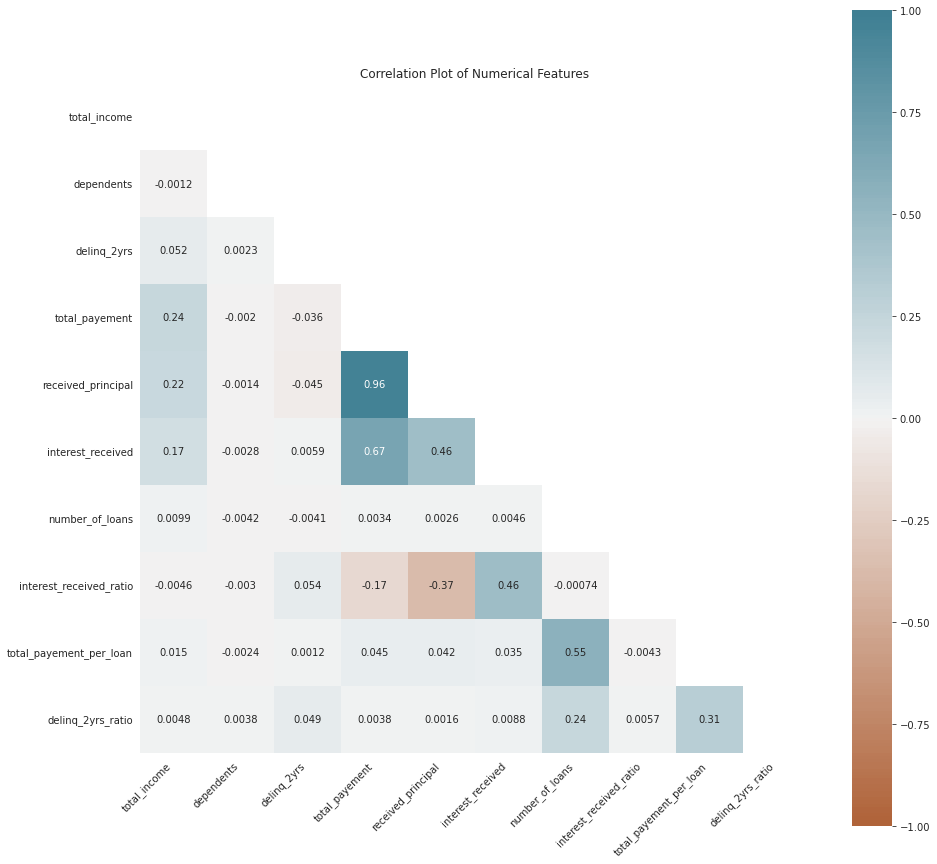

In [ ]:
e.correlation_plot()

Some Observations
- If shades are darker then it is highly correlated, may it can be positive or negative
<br> - Total payment and Received Principal are highly correlated (0.96)
<br> - Interest Received and Total payment are mildely correlated (0.67)

here we can drop feature any one from which are highly correlated or we can drop it later in Feature importance and feature selection

### Box Plot vs Label

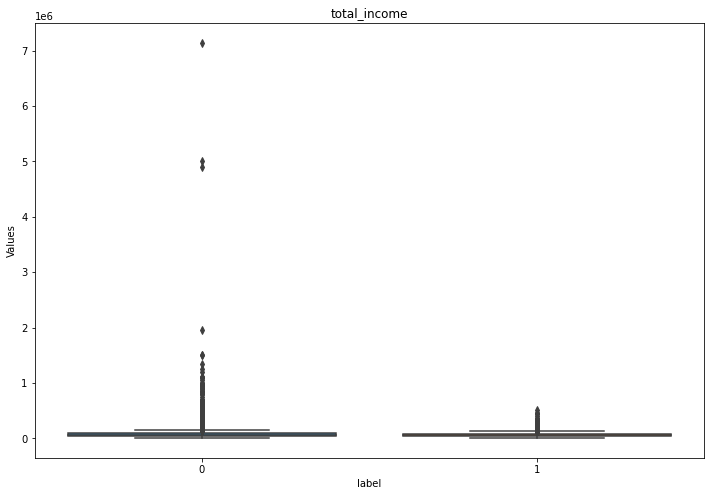

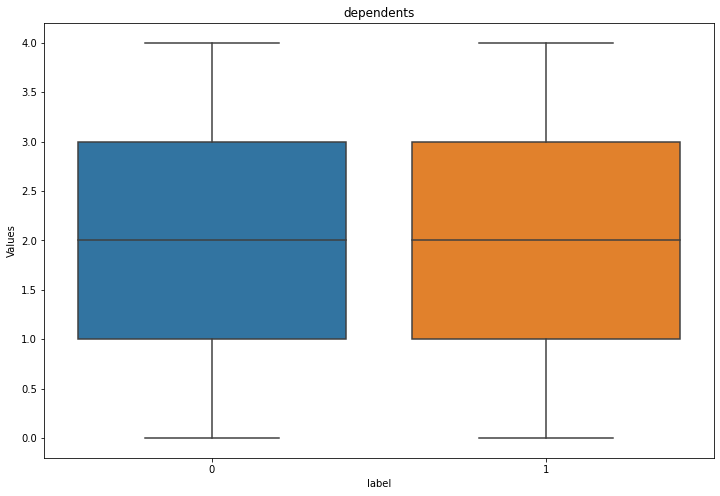

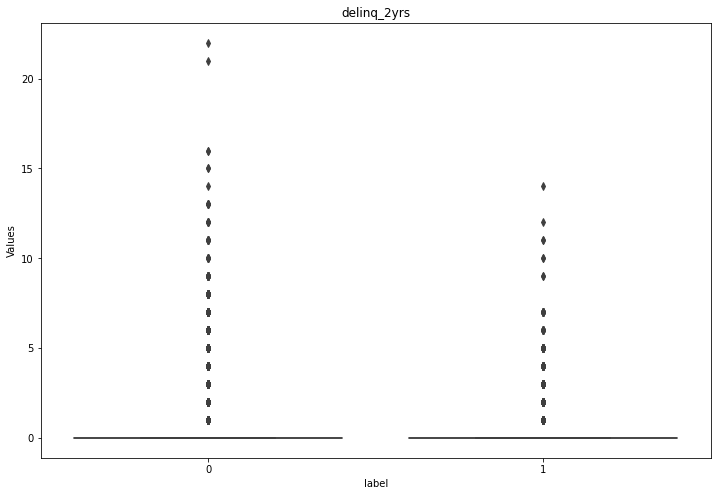

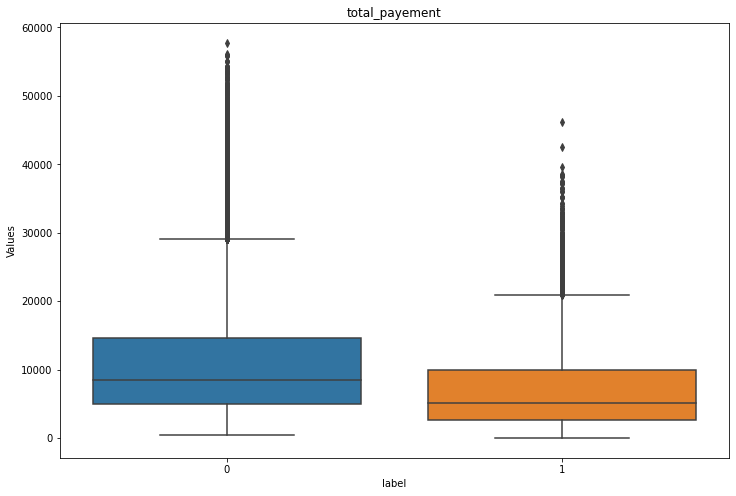

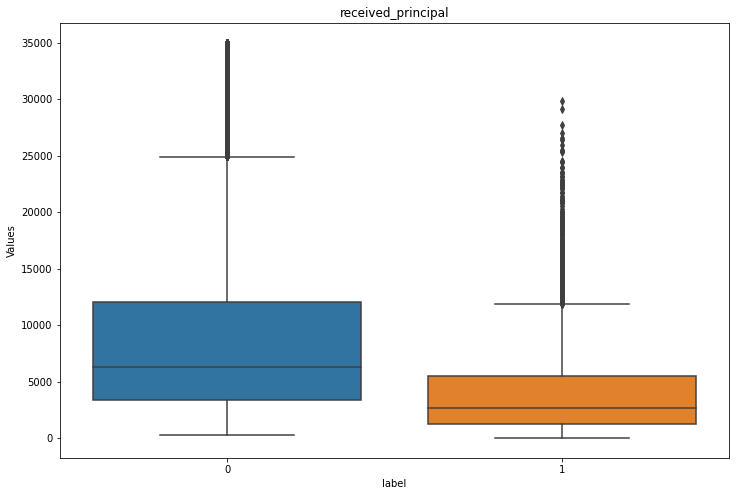

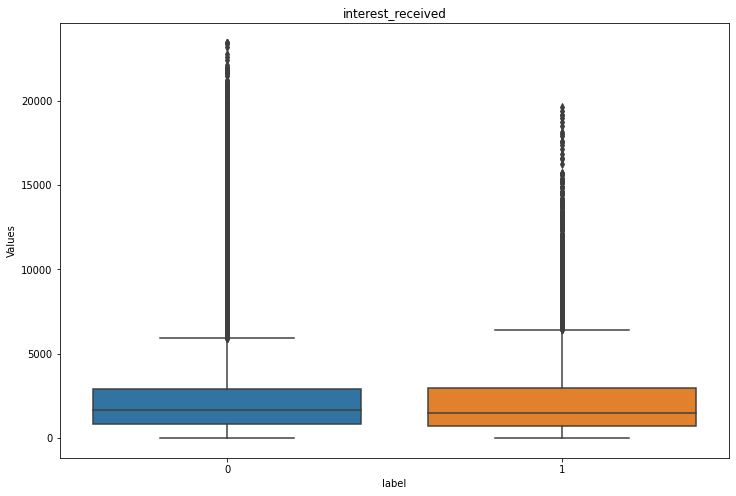

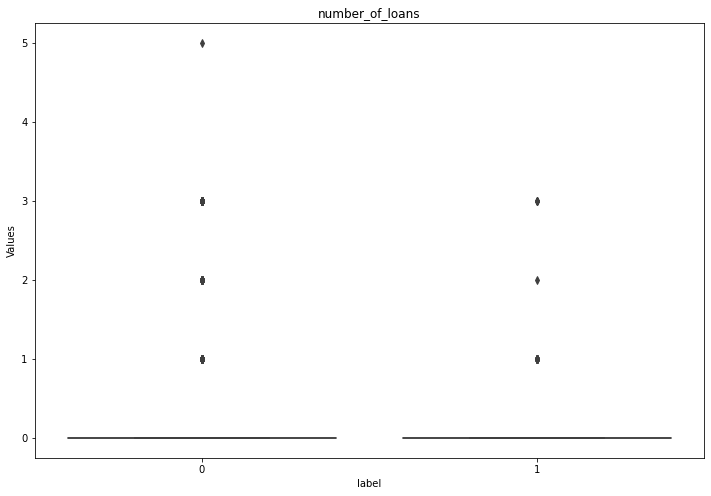

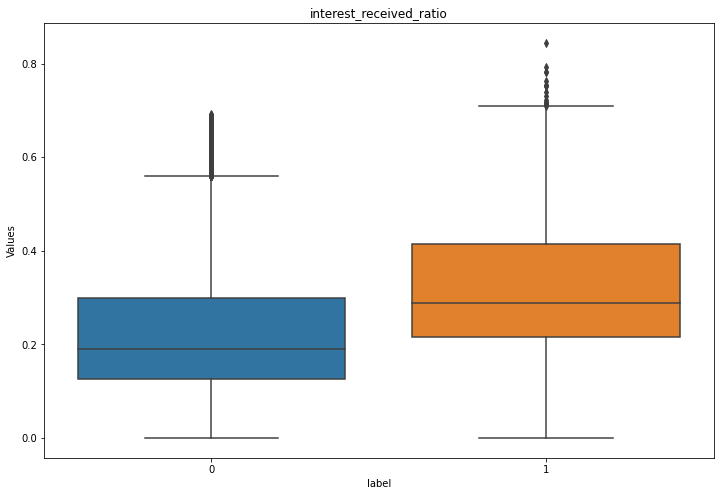

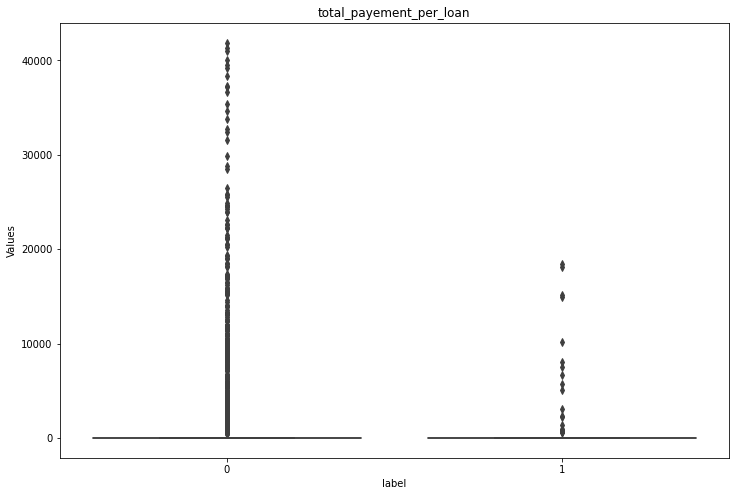

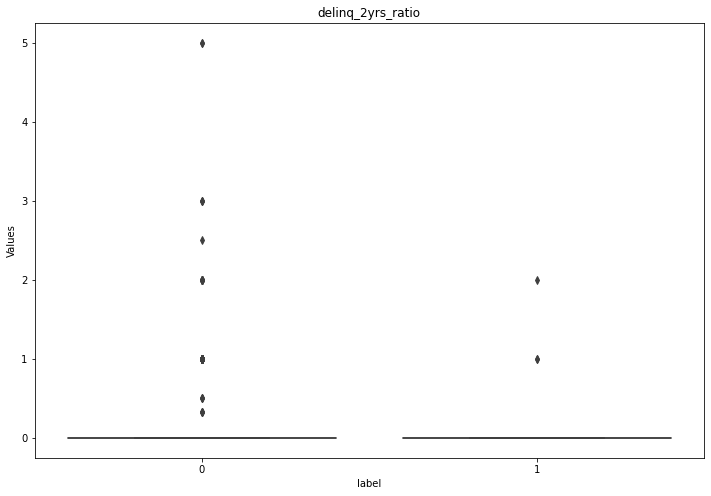

In [ ]:
# Box Plot Seggregated by Defaulter and Non Defaulters
e.box_plot(group = ['label'])

Observation
- Total payment is high the probability of default is low and Interest ratio is high then prob. of default is High
- If feature not Monotonic ralated with the label then we notdistingushed with BoxPlot.
- In a monotonic relationship, the variables tend to move in the same relative direction, but not necessarily at a constant rate. In a linear relationship, the variables move in the same direction at a constant rate
- Distribution of Total Payment, Received Principal, Interest Received Ratio is different for Defaulters and Non-Defaulters
<br>
<br>these can be some important features

# Categorical Features Transformation

- Category Encoders
<!-- <br> [Paper](https://arxiv.org/pdf/1904.13001.pdf) -->
<br> [Library](https://contrib.scikit-learn.org/category_encoders/)
<!-- <br> to understand Target Encoding better -->

- LightGBM model can consume Categorical feature in Row form, the Categorical feature which has only few unique values. If there are large number of unique value then there Sparsity increases and model leads to Overfit..
- OneHotEncoding traditional method to treat categorical feature but these are not best method to treat Cat feature which increase dimensinality so model tends to Overfit...
- So there is TargetEngoding which is solve problem of increase dimensionality..
- In Training data, for every class value in Categorical Feature find the mean of Target.
-

In [ ]:
cat_cols = train.drop(columns = id_cols).select_dtypes(include=['category', 'object']).columns

params = {"verbose":0,
          "cols":None,
          "drop_invariant":False,
          "return_df":True,
          "handle_missing":'value',
          "handle_unknown":'value',
          "min_samples_leaf":5000,
          "smoothing":1}

target_encoder = categorical_encoding(params)
target_encoder.fit(train, cat_cols, 'label')

In [ ]:
# transform data with target_encoder

train = target_encoder.transform(train)
val = target_encoder.transform(val)
hold_out = target_encoder.transform(hold_out)

In [ ]:
train.head()

,User_id,total_income,dependents,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo,label,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio,employment_type,tier_of_employment,industry,role,work_experience,married,home_type,pincode,has_social_profile,is_verified
0,7013527,125000.000,4,0,1824.150,971.460,852.690,0,0,90,90,90,90,90,90,202203,1,0.467,0.000,0.000,0.092,0.085,0.093,0.093,0.093,0.093,0.105,0.093,0.095,0.094
1,7014291,61000.000,1,0,22912.533,18000.000,4912.530,0,0,0,0,0,0,0,0,202203,0,0.214,0.000,0.000,0.144,0.146,0.093,0.093,0.093,0.094,0.084,0.093,0.091,0.094
2,7014304,30000.000,1,0,6672.050,5212.290,1459.760,0,0,0,0,0,0,0,0,202203,0,0.219,0.000,0.000,0.087,0.087,0.093,0.101,0.093,0.093,0.105,0.093,0.094,0.094
3,7031995,65000.000,3,0,11793.001,10000.000,1793.000,0,0,0,0,0,0,0,0,202203,0,0.152,0.000,0.000,0.087,0.087,0.093,0.101,0.093,0.093,0.105,0.093,0.095,0.091
4,7033985,90000.000,4,0,13252.855,11500.000,1733.990,0,0,0,0,0,0,0,0,202201,0,0.131,0.000,0.000,0.087,0.087,0.093,0.101,0.145,0.093,0.084,0.093,0.091,0.094


# Feature Selection


<br> There can be many methods to do feature selection like Mrmr, KS, Information Gain etc., Random Forest and Deep Decision Tree can also be used as Feature Selection</br>
<br>
**Random Forest** - Since Random Forest subset features too, so every feature gets chance to split tree
<br>
**Decision Tree** - Decision Tree Uses Greedy Algorithm to split Tree so choose between 2 correlated features which one is best
<br>
<br>Drop features which are of 0 importance in Random Forest and Decision Tree

## Random Forest

In [ ]:
rf_params = {"n_estimators":250, 'criterion':'entropy','verbose':False, 'n_jobs':25}
rf_zero_imp = random_forest_zero_importance(train, id_cols, 'label', rf_params)

In [ ]:
rf_zero_imp

17    pincode
Name: features, dtype: object

#### if 250 Decision tree in randomforest there subseting data and features and create large tree and every feature get chance to in Decision tree and if any feature not contributing any decision tree to improve performance in Randomforest then there not importance feature anywhere.. And also in randomforest 2 correlated feature, not split tree due to 2 correlated feature so we can descarded any one feature from them...
    

## Decision Tree

In [ ]:
dt_params = {}
dt_zero_imp = decision_tree_zero_importance(train, id_cols, 'label', dt_params)
dt_zero_imp

9     delinq_2yrs_ratio
17              pincode
Name: features, dtype: object

#### create deep Decision tree and find any feature not any kind of split from particular feature then that feature not importance in DT

## Zero Importance Columns

In [ ]:
drop_cols = list(set(rf_zero_imp) & set(dt_zero_imp))
print(drop_cols)

['pincode']


Since Pincode is of 0 importanc in Random Forest and Decision Tree, we will drop this features in model

# Model Development
## Hyperparameter Tuning

We will try to search hyperparameter using Hyperopt, Following are relevant links to understand Hyperopt better
<!-- - [Paper](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf) -->
- [Library](http://hyperopt.github.io/hyperopt/)

### Hyperopt
Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model. It can optimize a model with hundreds of parameters on a large scale. ( Smartly check previous hyperparameter happened with past and take next parameter based on )


Hyperopt tries to minimize of score (to be defined by user) by smartly iterating though various combination of hypeparameters in given space
<br>
Score = (Train ROC AUC - Val ROC AUC + 1)/(Val ROC AUC)
<br>
<br>
**Intution**
- Train ROC AUC - Val ROC AUC will reduce overfitting
<br>
- 1/(Val ROC AUC) will increase ROC AUC for Validation Set
</br>
After Every Iteration we are appending results to the results of existing runs and saving to hyperopt_results.csv, so in case we halt the run in between, we will not loose results

<br></br>
**Setting**
<br>- Loss Function = LogLoss
<br>- Implementation = Lightgbm Implementation of Boosting Algorithm
<br>- Primary Evalution Metric - ROC AUC
<br>- Hypeparameter Selection - Hyperopt

In [ ]:
result_ho = pd.DataFrame()
i = 0

## Defining Objective Function
## will return the score to optimise
def objective(space):

    global i
    global result_ho

    #Creating Lightgbm DataFrame
    lgb_train = lgb.Dataset(train.drop(columns = id_cols+drop_cols), label = train.label)
    lgb_val = lgb.Dataset(val.drop(columns = id_cols+drop_cols), label = val.label)

    #Parameters of model
    params = {
        'num_leaves': int(space['num_leaves']),
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'objective': 'binary',
        'metric': 'auc',
        "boosting": "gbdt",
        'feature_fraction' : space['feature_fraction'],
        'max_bin' : int(space['max_bin']),
        'min_data_in_leaf': int(space['min_data_in_leaf']),
        "min_data_in_bin": int(space['min_data_in_bin']),
        "bagging_freq": 20,
        "random_seed": 2019,
        "lambda_l1": space['lambda_l1'],
        "lambda_l2": space['lambda_l2'],
        'pos_bagging_fraction' : space['pos_bagging_fraction'],
        'neg_bagging_fraction' : space['neg_bagging_fraction'],
        'verbose': -1
    }

    evals_result = {}

    clf = lgb.train(params, lgb_train, 20000, valid_sets=lgb_val,
                valid_names='val',
                early_stopping_rounds=50,
                verbose_eval=False, evals_result=evals_result)
    gc.collect()

    result = pd.DataFrame(clf.params, index=[0])

    ## Calculating AUC
    pred_train = clf.predict(train[clf.feature_name()])
    pred_val = clf.predict(val[clf.feature_name()])
    pred_hold_out = clf.predict(hold_out[clf.feature_name()])

    gc.collect()
    train_auc = roc_auc_score(train.label, pred_train)#, num_iteration=clf.best_iteration)
    val_auc = roc_auc_score(val.label, pred_val)#, num_iteration=clf.best_iteration)
    hold_out_auc = roc_auc_score(hold_out.label, pred_hold_out)#, num_iteration=clf.best_iteration)
    gc.collect()

    # score: ratio differance between train and val auc and validation AUC
    # 1. to check overfitting differance between tran and test AUC is less
    # 2. Goodness: accuracy (Bias and Variance maintained)
    # we want to minimise the score so tooke (1/validation AUC)
    score = (abs(train_auc - val_auc) + 1)/((1+val_auc)*(1+val_auc))

    result["train_auc"] = train_auc
    result["val_auc"] = val_auc
    result["hold_out_auc"] = hold_out_auc
    result["train_test_diff"] = train_auc - val_auc
    result["n_estimators"] = clf.best_iteration
    result["score"] = score

    del clf

    result_ho = result_ho.append(result)
    result_ho.to_csv('hyperopt_results.csv', index=False)
    i = i+1

    return (score)

In [ ]:
## Hyperparameter space
## Space is selection of data point from the given distribution
## Distribution is defined for every hyperparameter seperately

space = {
    'num_leaves': hp.quniform('num_leaves', 2, 24, 1), # Uniform integer between 2 and 24
    'max_depth': hp.quniform('max_depth', 2, 12, 1), # Uniform integer between 2 and 12
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.015), # Values between 0.005 to 0.015
    'feature_fraction' : hp.uniform('feature_fraction', 0.1, 1), # Values between 0.1 to 1
    'max_bin' : hp.quniform('max_bin', 10, 100, 10),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 25, 1000, 25),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 50),
    'lambda_l2' : hp.uniform('lambda_l2', 0, 50),
    'min_data_in_bin' : hp.quniform('min_data_in_bin', 5, 100, 5),
    'pos_bagging_fraction' : hp.uniform('pos_bagging_fraction', 0.1, 1),
    'neg_bagging_fraction' : hp.uniform('neg_bagging_fraction', 0.1, 1)
    }

- The objective function to minimize
- The defined search space
- The search algorithm to use such as Random search, TPE (Tree Parzen Estimators), and Adaptive TPE. NB: hyperopt.rand.suggest and hyperopt.tpe.suggest provides logic for a sequential search of the hyperparameter space.
- The maximum number of evaluations.

In [ ]:
# finding the minima..
# The fmin function is the optimization function that iterates on different sets of algorithms and
# their hyperparameters and then minimizes the objective function
# optimization algorithm tpe

best=fmin(fn = objective, # function to optimize
          space = space, # space from which hyperparameter to be choosen (parameter dict..)
          algo = tpe.suggest, # optimization algorithm, hyperopt will select its parameters automatically
          max_evals = 50,    # how many iteration
          rstate = np.random.default_rng(7)
         )

100%|██████████| 50/50 [11:57<00:00, 14.36s/trial, best loss: 0.26055619307290495]


## Model Selection

From Hyperopt Results we will choose best parameters according to following criteria. It is not necessary we use that particular hyperparameter
- High Score
- High Validation AUC
- Low Overfitting: minimum train_test_diff

In [ ]:
hyperopt_results = pd.read_csv('hyperopt_results.csv')

In [ ]:
hyperopt_results.head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,bagging_freq,random_seed,lambda_l1,lambda_l2,pos_bagging_fraction,neg_bagging_fraction,verbose,num_iterations,early_stopping_round,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
0,18,3,0.009,binary,auc,gbdt,0.202,80,875,55,20,2019,1.055,21.582,0.334,0.647,-1,20000,50,0.891,0.894,0.890,-0.003,24,0.279
1,10,6,0.015,binary,auc,gbdt,0.238,10,225,65,20,2019,3.617,4.936,0.460,0.468,-1,20000,50,0.892,0.897,0.895,-0.005,29,0.279
2,9,8,0.009,binary,auc,gbdt,0.789,90,550,55,20,2019,6.798,6.654,0.376,0.866,-1,20000,50,0.913,0.917,0.912,-0.004,27,0.273
3,19,9,0.009,binary,auc,gbdt,0.475,70,100,60,20,2019,1.080,3.266,0.303,0.894,-1,20000,50,0.973,0.964,0.963,0.008,3496,0.261
4,6,12,0.007,binary,auc,gbdt,0.908,60,500,25,20,2019,15.228,35.308,0.138,0.792,-1,20000,50,0.938,0.938,0.937,-0.000,1560,0.266


In [ ]:
hyperopt_results.sort_values(by = 'score').head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,bagging_freq,random_seed,lambda_l1,lambda_l2,pos_bagging_fraction,neg_bagging_fraction,verbose,num_iterations,early_stopping_round,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
21,12,9,0.010,binary,auc,gbdt,0.669,100,625,30,20,2019,1.118,1.748,0.659,0.544,-1,20000,50,0.971,0.965,0.964,0.006,3041,0.261
24,13,8,0.007,binary,auc,gbdt,0.679,100,1000,25,20,2019,6.275,0.576,0.776,0.515,-1,20000,50,0.969,0.964,0.963,0.006,5096,0.261
37,8,7,0.009,binary,auc,gbdt,0.951,80,125,30,20,2019,2.641,5.610,0.837,0.341,-1,20000,50,0.968,0.963,0.963,0.005,4420,0.261
22,12,9,0.009,binary,auc,gbdt,0.672,70,650,25,20,2019,2.435,0.392,0.632,0.554,-1,20000,50,0.970,0.964,0.962,0.006,3489,0.261
27,7,10,0.008,binary,auc,gbdt,0.745,100,775,15,20,2019,0.043,30.191,0.867,0.502,-1,20000,50,0.966,0.962,0.961,0.004,6067,0.261


- High score at 21 index

In [ ]:
hyperopt_results.sort_values(by = 'val_auc', ascending=False).head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,bagging_freq,random_seed,lambda_l1,lambda_l2,pos_bagging_fraction,neg_bagging_fraction,verbose,num_iterations,early_stopping_round,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
21,12,9,0.010,binary,auc,gbdt,0.669,100,625,30,20,2019,1.118,1.748,0.659,0.544,-1,20000,50,0.971,0.965,0.964,0.006,3041,0.261
25,16,8,0.006,binary,auc,gbdt,0.697,100,975,30,20,2019,7.115,16.831,0.788,0.480,-1,20000,50,0.971,0.964,0.963,0.007,6822,0.261
3,19,9,0.009,binary,auc,gbdt,0.475,70,100,60,20,2019,1.080,3.266,0.303,0.894,-1,20000,50,0.973,0.964,0.963,0.008,3496,0.261
24,13,8,0.007,binary,auc,gbdt,0.679,100,1000,25,20,2019,6.275,0.576,0.776,0.515,-1,20000,50,0.969,0.964,0.963,0.006,5096,0.261
22,12,9,0.009,binary,auc,gbdt,0.672,70,650,25,20,2019,2.435,0.392,0.632,0.554,-1,20000,50,0.970,0.964,0.962,0.006,3489,0.261


- High validation AUC and minium train_test_diff (Low Overfitting) at 21 index

In [ ]:
# check the minimum score and select the index as best parameter index

best_param_index = hyperopt_results.index[hyperopt_results['score'] == hyperopt_results['score'].min()].tolist()[0]
print( best_param_index)
lgbm_params = dict(hyperopt_results.iloc[best_param_index,:19])

21


In [ ]:
lgbm_params

{'num_leaves': 12,
 'max_depth': 9,
 'learning_rate': 0.0100646503850957,
 'objective': 'binary',
 'metric': 'auc',
 'boosting': 'gbdt',
 'feature_fraction': 0.6689684436651296,
 'max_bin': 100,
 'min_data_in_leaf': 625,
 'min_data_in_bin': 30,
 'bagging_freq': 20,
 'random_seed': 2019,
 'lambda_l1': 1.1183880580478147,
 'lambda_l2': 1.748336004645278,
 'pos_bagging_fraction': 0.6594746296368389,
 'neg_bagging_fraction': 0.5439750792861977,
 'verbose': -1,
 'num_iterations': 20000,
 'early_stopping_round': 50}

## Selected Model : LightGBM

LightGBM Model:

- Boosting Based mode: sequential fashion and try to minimise residual
- Other tree based algo grows level wise But This Lightgbm algo grow leaf-wise
- very fast distributed.
- consume categorical feature ( few unique value categorical feature: low in sparsity directly fit in LightGBM model)
- Null value auto handle
- very fast as compare to XGBoost
- **Hyperparameter parameter:**
- num_leaves: default 31, max number of leaves in one tree
- max_depth: limit the max depth for tree model.Tree still grows leaf-wise
- learning_rate: how processed with Gradient Descent...
- Objective: Binary/ logloss
- metric: early stopping.. AUC
- boosting: technique for boosting,  randomForest/ gbdt...
- feature_fraction: percentage of feature used particular tree building...
- max_bin:max number of bins that feature values will be bucketed in,small number of bins may reduce training accuracy but may increase general power.
- min_data_in_bin, min_data_in_leaf: minimal number of data inside one bin/leaf
- bagging_freq: at what freq want to reshuffle data
- random_seed: random seed for sampling data to construct histogram bins
- lambda_l1, lambda_l2: regularization parameter..
- pos_bagging_fraction/ neg_bagging_fraction: percentage of class while take in subset in data
- verbose:



<!-- - [Paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) -->
- [Library](https://lightgbm.readthedocs.io/en/v3.3.2/)

In [ ]:
lgb_train = lgb.Dataset(train.drop(columns = id_cols+drop_cols), label = train['label'])
lgb_val = lgb.Dataset(val.drop(columns = id_cols+drop_cols), label = val['label'])

evals_result = {}

# 20000 max iteration possible while training lgb
# early_stopping_rounds is 50

clf = lgb.train(lgbm_params, lgb_train, 20000, valid_sets=lgb_val,
                valid_names='val',
                early_stopping_rounds=50,
                verbose_eval=False, evals_result=evals_result)

In [ ]:
clf

In [ ]:
evals_result

{'val': OrderedDict([('auc',
               [0.9032342253114315,
                0.9066571486691964,
                0.9067746277875766,
                0.908679448663725,
                0.9095965899780054,
                0.9116346032592046,
                0.9120799342715277,
                0.9127515228885155,
                0.9126849850104165,
                0.9130374086421622,
                0.9129025625680774,
                0.917013515169408,
                0.9177875352027369,
                0.9193396648409474,
                0.9211160896384131,
                0.9235138205355201,
                0.924373735294851,
                0.9251929258810855,
                0.9253269073813185,
                0.9268058776035972,
                0.9278660029648845,
                0.928200668524183,
                0.9282289524401904,
                0.9281268846938028,
                0.9280743103695794,
                0.9277436451797695,
                0.9276751517179583,
   

# Model Evalution

In [ ]:
#Predictions from Model on Training, Validation and Hold Out
pred_train = clf.predict(train[clf.feature_name()])
pred_val = clf.predict(val[clf.feature_name()])
pred_hold_out = clf.predict(hold_out[clf.feature_name()])

In [ ]:
pred_train

array([0.95766168, 0.0100705 , 0.21664071, ..., 0.18183399, 0.01133472,
       0.00835971])

- score between 0 to 1: higher the score higher the probability of being class 1



### ROC AUC, PR AUC, KS Stats

In [ ]:
#Printing ROC AUC, PR AUC for Class 1 and Class 0
print("ROC AUC")                           # ROC AUC must lie in  between 0.5 to 1
roc_auc([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])
print("")

print("Class 1 PR AUC")                   # plot Precision and Recoll AUC between 0 to 1 for class 1 and 0
pr_auc([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])
print("")

print("Class 0 PR AUC")
pr_auc([1-train.label,1-val.label,1-hold_out.label], [1-pred_train, 1-pred_val, 1-pred_hold_out])
print("")

ROC AUC
0.9709666608309787
0.9649508759429978
0.9635950364843274

Class 1 PR AUC
0.883796268964256
0.8792279856483648
0.8678364668760414

Class 0 PR AUC
0.9963933861427327
0.9949638969488055
0.9953873339982944



- ROC-AUC for Training and Validation score
- both approx same score means best Model
- Training score more means more Bias
- Training score less means more variance
_

### ROC Curve

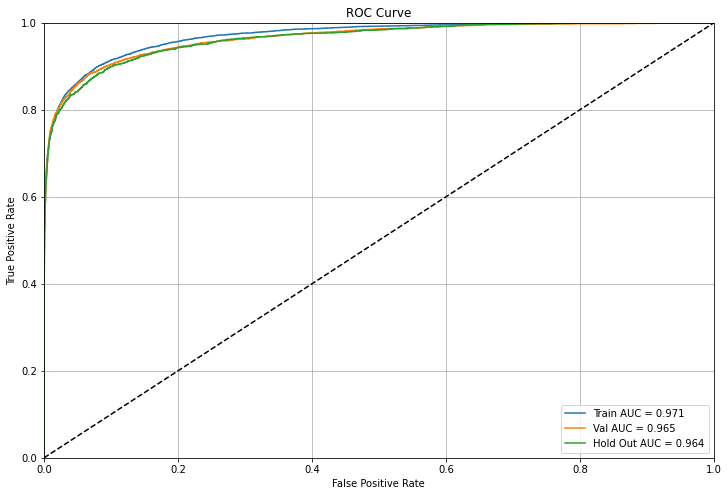

In [ ]:
roc_auc_curve([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])

### PR Curve

PR Curve for Class 1


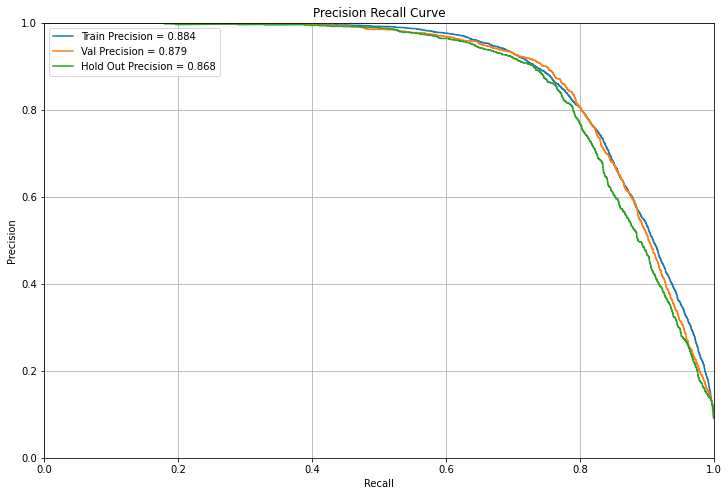

In [ ]:
print("PR Curve for Class 1")
pr_auc_curve([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])

PR Curve for Class 0


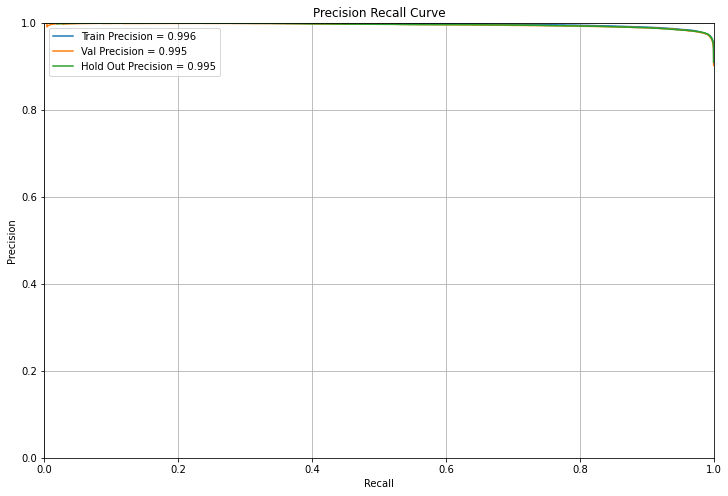

In [ ]:
print("PR Curve for Class 0")
pr_auc_curve([1-train.label,1-val.label,1-hold_out.label], [1-pred_train, 1-pred_val, 1-pred_hold_out])

### Score Distribution

In [ ]:
help(score_distribution)

Help on function score_distribution in module utils:

score_distribution(target_list, pred_list, data_type_list)
    Print Score Distribution Plots
    Parameters
    ----------
    target_list : list
        List of Multiple Target Arrays.
    pred_list : list
        List of Multiple Predicted Array Arrays
    data_type_list : list
        Data Tagging like Train, Val, Hold Out



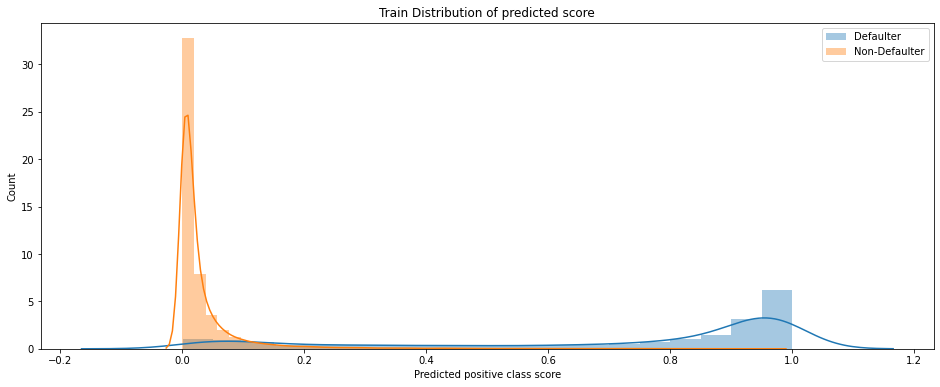

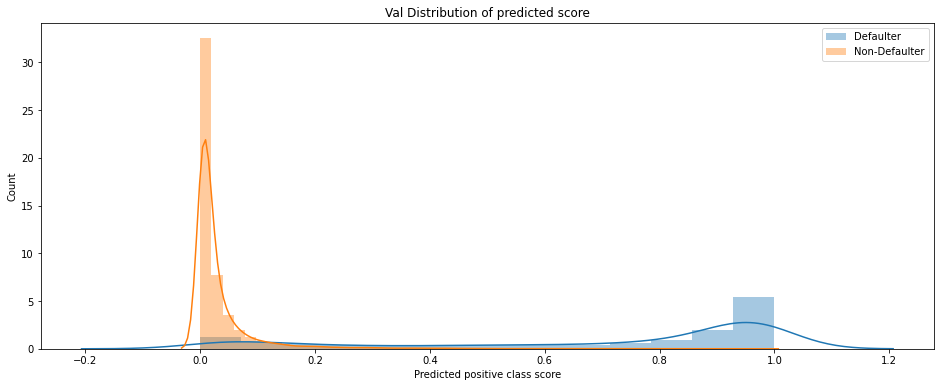

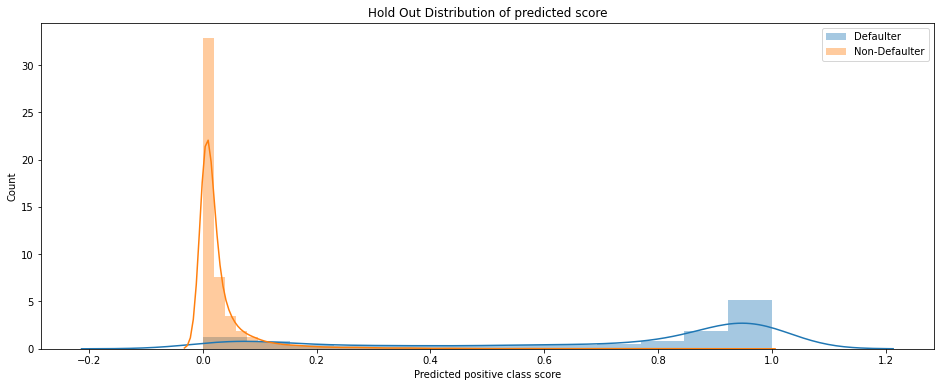

In [ ]:
# more the Segregation (Segregation can also involve the separation of items from a larger group) in between class plot
# that is the better the model

score_distribution([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out], ["Train","Val","Hold Out"])

## Feature Importance

- LightGBM itself throw out feature importance..
- two types of Feature Importance from LightGBM model: Split and Gain

### Split & Gain

#### Split: how many times feature is used to split in a tree..
#### Gain: before split what is Entropy and after split what is entropy of particular feature and Gain is reduction in Entropy..

- model is learned on training so feature importance also on train dataset,
- check feature importance, which feature has more gain and maximum times splits then that feature is more important...

In [ ]:
pd.DataFrame({"feature":clf.feature_name(),"split":clf.feature_importance('split'), "gain":clf.feature_importance('gain')})

,feature,split,gain
0,total_income,2541,22366.545
1,dependents,453,1711.251
2,delinq_2yrs,256,1490.211
3,total_payement,5845,129490.195
4,received_principal,8140,442117.261
5,interest_received,3896,88885.044
6,number_of_loans,0,0.000
7,interest_received_ratio,6914,268705.206
8,total_payement_per_loan,0,0.000
9,delinq_2yrs_ratio,0,0.000


In [ ]:
feature_importance = pd.DataFrame({"feature":clf.feature_name(),"split":clf.feature_importance('split'), "gain":clf.feature_importance('gain')}).sort_values(by = 'gain', ascending = False)
feature_importance.iloc[:10,:]

,feature,split,gain
4,received_principal,8140,442117.261
7,interest_received_ratio,6914,268705.206
12,industry,1226,140634.732
3,total_payement,5845,129490.195
5,interest_received,3896,88885.044
14,work_experience,552,46334.458
11,tier_of_employment,1905,29678.155
0,total_income,2541,22366.545
10,employment_type,352,3008.691
1,dependents,453,1711.251


### SHAP

Literature about SHAP
<br>
<!-- - [Paper](https://arxiv.org/pdf/1705.07874.pdf) -->
- [Library](https://shap.readthedocs.io/en/latest/index.html)
</br>

**How to Read SHAP**
- Value of features on color scale vary from Blue to Red where Red is high and Blue is low
- Right Side of Grey Vertical Line is for class 1 and Left side is for Class 0

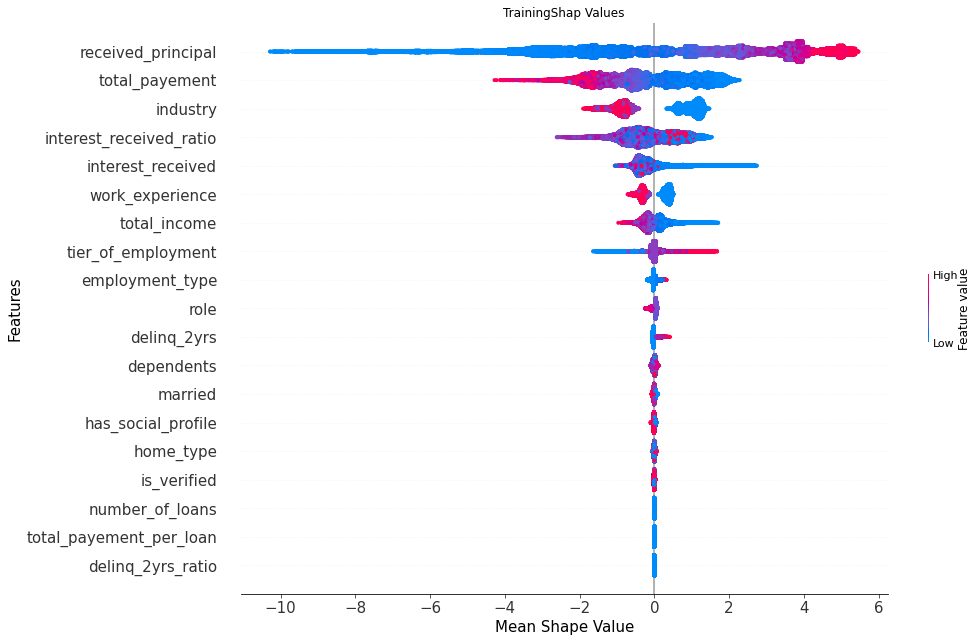

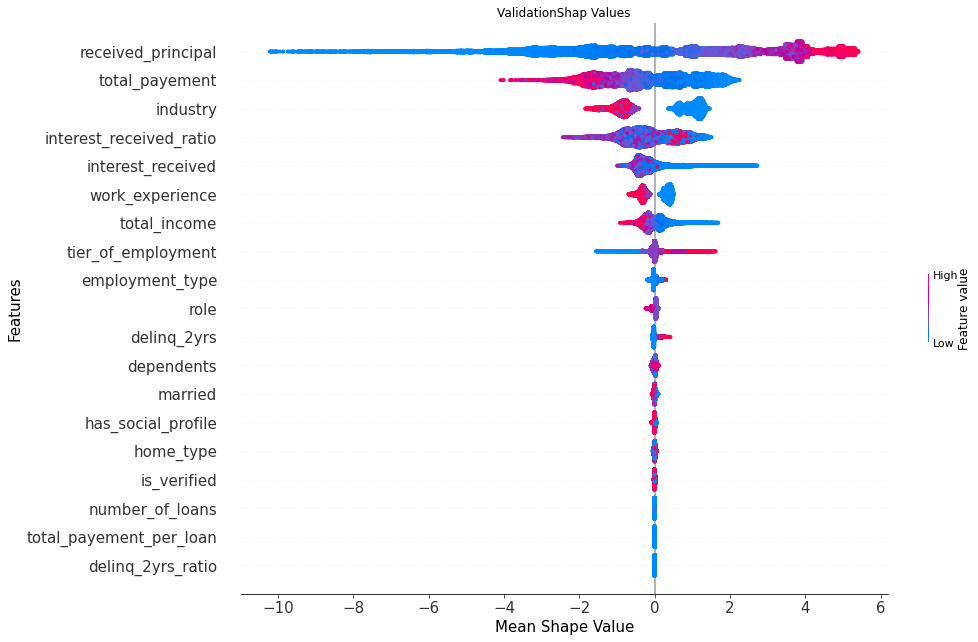

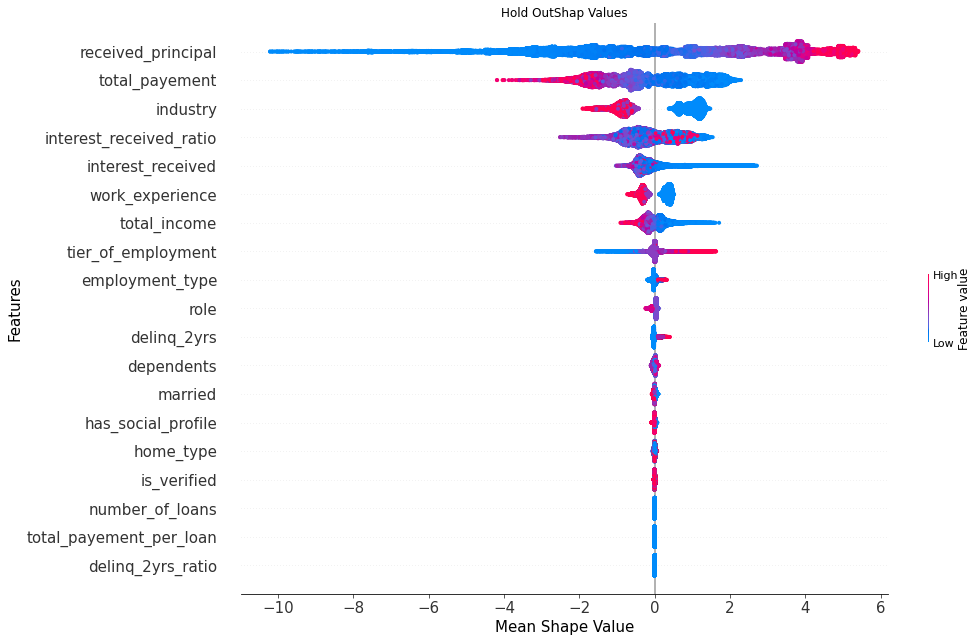

In [ ]:
import shap
data_list = [train,val,hold_out]
data_type_list = ['Training', 'Validation', 'Hold Out']
shap_importance(clf, data_list, data_type_list)

Key Points
- Top features are consistent across Training, Validation, Hold Out (Higher the inconsistency, higher the chances the model is overfitting and will decay soon)
- If top feature maintain there state or position in all above output, if it fails when top feature in train that are not at top position or mismatched there position then there is overfitting happens....

# Making Sense of Score
## Class Rate Curve

This Curve Tells 2 important things
1. Default rate across different score bucket for Train, Validation and Hold Out
2. User Distribution across different score bucket for Train, Validation and Hold Out

<br>
In Case User Distribution across different score bucket is very inconsistent in Train, Validation and Hold Out that means there is shift in domain of Out of Time Data

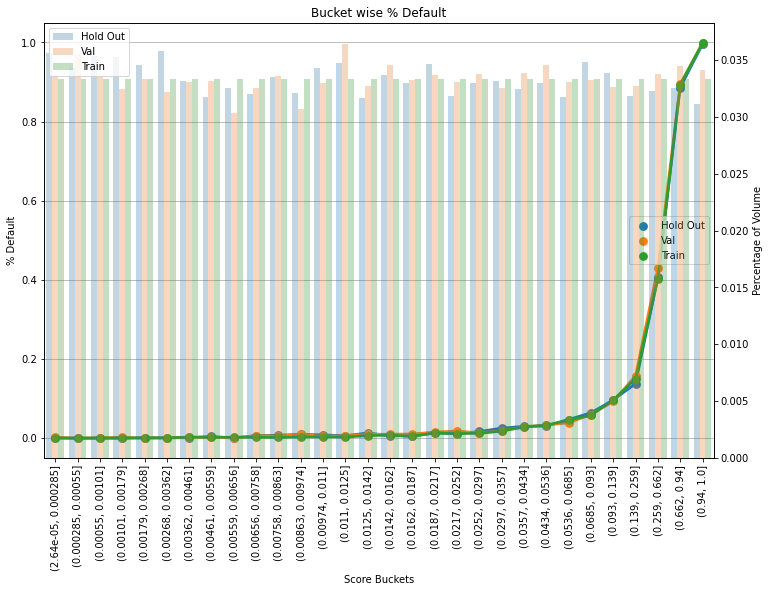

In [ ]:
target_list = [train.label, val.label, hold_out.label]
pred_list = [pred_train, pred_val, pred_hold_out]
data_type_list = ['Train', 'Val', 'Hold Out']
class_rate(target_list, pred_list, data_type_list)

## Right Threshold

In [ ]:
cutoff_score(val.label, pred_val, 0.01)  # 1% rate

0.06616398453599784

In [ ]:
# default_rate 10 %

cutoff_score(val.label, pred_val, 0.1)

0.9999382490234409

- tune the default rate in above cutoff_score and find the NPA Rate..
- NPA Rate: Non Performing Assets. Definition: A non performing asset (NPA) is a loan or advance for which the principal or interest payment remained overdue for a period of 90 days